#  Используемые библиотеки и классы

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 5.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

import dataclasses
from dataclasses import dataclass
from typing import Union, Callable, Optional
from copy import deepcopy

import warnings
from  scipy.stats import norm
warnings.filterwarnings("ignore")

Heston model can be written in following way:

$$dS_t/S_t  = rdt + \sqrt{V_t} dW_1$$

$$dV_t = \kappa (\bar V-V_t)dt + \gamma \sqrt V_t dW_2$$

$$dW_1 dW_2 = \rho dt$$

In [3]:
@dataclass
class StockOption:
    strike_price: Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call: bool

@dataclass
class MarketState:
    stock_price: Union[float, np.ndarray]
    interest_rate: Union[float, np.ndarray]  # r, assume constant
    volatility: Union[float, np.ndarray]  # sigma, annualized

@dataclass
class HestonParameters:
    N : int # число акций в модели
    corMatrix : np.ndarray # корреляционная матрица между всеми винеровскими процессами в модели, размера 2N*2N   
    kappa:  Union[float, np.ndarray] # скорость возврата к среднему
    gamma:  Union[float, np.ndarray] # vol of vol
    vbar:  Union[float, np.ndarray] # долгосрочная средняя волатильность 
    v0:  Union[float, np.ndarray] # стартовая волатильность

In [4]:
def price(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    # ф-ия вычисляет B-S цену опциона
    if(option.is_call) : 
      a=state.stock_price*sps.norm.cdf(1/(state.volatility*np.power(option.expiration_time,0.5))*(np.log(state.stock_price/option.strike_price)+(state.interest_rate+np.power(state.volatility,2)/2)*option.expiration_time))
      b=option.strike_price*np.exp(-state.interest_rate*option.expiration_time)*sps.norm.cdf(1/(state.volatility*np.power(option.expiration_time,0.5))*(np.log(state.stock_price/option.strike_price)+(state.interest_rate-np.power(state.volatility,2)/2)*option.expiration_time))
      return a-b
    else:
      a=-state.stock_price*sps.norm.cdf(-1/(state.volatility*np.power(option.expiration_time,0.5))*(np.log(state.stock_price/option.strike_price)+(state.interest_rate+np.power(state.volatility,2)/2)*option.expiration_time))
      b=option.strike_price*np.exp(-state.interest_rate*option.expiration_time)*sps.norm.cdf(-1/(state.volatility*np.power(option.expiration_time,0.5))*(np.log(state.stock_price/option.strike_price)+(state.interest_rate-np.power(state.volatility,2)/2)*option.expiration_time))
      return a+b

def delta(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    S = state.stock_price
    r = state.interest_rate
    sigma = state.volatility
    K = option.strike_price
    T = option.expiration_time
    d_1 = 1 / sigma / np.sqrt(T) * (np.log(S/K) + (r + 0.5*sigma*sigma) * T)
    d_2 = d_1 - sigma * np.sqrt(T)
    if (option.is_call) :
      return sps.norm.cdf(d_1)
    else :
      return -sps.norm.cdf(-d_1)

# Реализация схемы Эйлера для модели Хестона

In [5]:
def simulate_paths_heston_euler(time: Union[float, np.ndarray],
                                n_simulations: int,
                                state: MarketState,
                                heston_params: HestonParameters) -> dict:
    '''
    Simulates price and volatility process evaluating it at given time points 
    using Euler scheme. 
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        state (MarketState): initial market state to start from.
        heston_params (HestonParameters): parameters of Heston model.
        
    Returns:
        dict: simulated asset and volatility paths.
    '''
    
    # initialize market and model parameters
    r, s0 = state.interest_rate, state.stock_price
    
    N, corMatrix, v0, kappa, vbar, gamma = heston_params.N, heston_params.corMatrix, \
                      heston_params.v0, heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    sqrtCorMatrix=np.linalg.cholesky(corMatrix)
    # initialize noise arrays
    Z = np.random.normal(size=(2*N, n_simulations, np.shape(time)[0]))
    
    #initialize zero array for volatility values
    V = np.zeros([N, n_simulations, np.shape(time)[0]])
    for i in range(N): V[i,:,0] = v0[i]
    
    #initialize zero array for logprice values
    logS = np.zeros([N, n_simulations, np.shape(time)[0]])
    for i in range(N): logS[i,:,0] = np.log(s0[i]) 

    for i in range(1,np.shape(time)[0]) :
      dt=time[i]-time[i-1]
      kappa*((vbar-V[:,:,i-1].T))
      V[:,:,i]=V[:,:,i-1]+(kappa*(vbar-V[:,:,i-1].T)).T*dt+\
                                                 (gamma*(np.sqrt(V[:,:,i-1]*dt).T)).T*Z[N:,:,i-1]
      V[:,:,i]=np.maximum(V[:,:,i],0)
      logS[:,:,i]=logS[:,:,i-1]+(r-V[:,:,i-1]/2)*dt+np.sqrt(V[:,:,i-1]*dt)*\
                                                 np.matmul(sqrtCorMatrix[:N,:],Z[:,:,i-1])

    
    simulated_paths = {"asset": np.exp(logS), "volatility": V}
    
    return simulated_paths

In [6]:
def plot_random_paths(times: np.array, 
                      simulated_paths: dict,
                      type_of_scheme: str = "Euler",
                      plot_paths: int = 15):
    '''
    Plots some simulated paths.
    
    Args:
        simulated_paths (dict): paths of an asset and volatility values.
    '''
    #take random paths indexes
    n_simulatinos = simulated_paths["asset"].shape[1]
    random_indexes = np.random.choice(n_simulatinos, plot_paths)
    
    #take paths corresponding to sampled indexes
    asset_paths = simulated_paths["asset"][0,random_indexes,:]
    volatility_paths = simulated_paths["volatility"][0,random_indexes,:]
    
    #plot asset prices and volatilities 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,9))
    fig.suptitle("{} scheme simulated Heston model".format(type_of_scheme))    
    fig.subplots_adjust(hspace=0.4)
    
    for i in range(plot_paths):
        ax1.plot(times, asset_paths[i])
        ax2.plot(times, volatility_paths[i])
        
    ax1.set_xlabel('time')
    ax1.set_ylabel('Asset')
    ax1.grid(True)
    
    ax2.set_xlabel('time')
    ax2.set_ylabel('Volatility')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()  

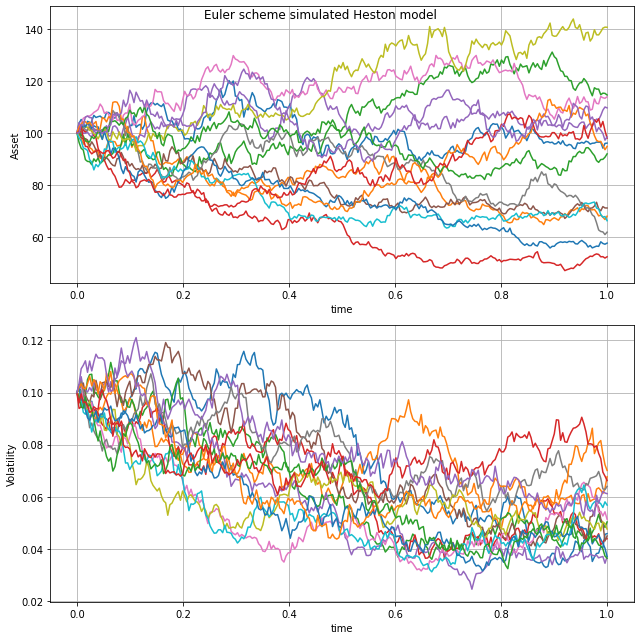

In [7]:
time = np.linspace(0, 1, 252)
N=2
heston_parameters = HestonParameters(N=N ,corMatrix=np.eye(2*N),
                                     kappa = [3,3], gamma = [0.15,0.1], 
                                      vbar = [0.05,0.05], 
                                     v0 = [0.1,0.1])

state = MarketState(stock_price = [100,100], interest_rate = 0.01, volatility=0.25)

n_simulations = 10000

paths = simulate_paths_heston_euler(time, n_simulations, state, heston_parameters)

plot_random_paths(time, paths)

# Про робастность модели B-S

Мы хотим численно проверить теорему о робастности модели B-S, на примере low-volatility индекса : $I_t:=\sum_{i=1}^{k}\frac{\frac{S^i_t}{\sqrt{v_t^i}}}{\sum_{j=1}^{k}\frac{1}{\sqrt{v_t^j}}},$ где $v_t^i-$значение поцесса дисперсии для $i-$ой акции а момент $t$, т.е. веса акций обратно пропорциональны их волатильностям.

In [8]:
def simulate_paths_Index(
                         simulated_paths: dict # содержит как траектории цен так и траектории дисперсии
                         ) -> np.ndarray:
  # ф-ия реализует формулу, приведённую выше
  asset_paths = simulated_paths["asset"]
  volatility_paths = np.sqrt(simulated_paths["volatility"])

  #initialize zero array for index values
  index_value = np.zeros([np.shape(asset_paths)[-2], np.shape(asset_paths)[-1]])

  for i in range(np.shape(asset_paths)[-1]) :
    index_value[:,i]=np.sum(asset_paths[:,:,i]*1/(np.maximum(volatility_paths[:,:,i],1e-9)), axis=0)/ \
                                            np.sum(1/(np.maximum(volatility_paths[:,:,i],1e-9)), axis=0)
  return index_value

In [9]:
index_level=simulate_paths_Index(paths)

In [10]:
def plot_random_paths_index(times: np.array, 
                      simulated_paths: np.ndarray,
                      subtitle: str,
                      plot_paths: int = 15):
    '''
    Plots some simulated paths.
    
    Args:
        simulated_paths (dict): paths of an asset and volatility values.
    '''
    #take random paths indexes
    n_simulatinos = simulated_paths.shape[0]
    random_indexes = np.random.choice(n_simulatinos, plot_paths)
    
    #take paths corresponding to sampled indexes
    index_paths = simulated_paths[random_indexes,:]
    
    #plot asset prices and volatilities 
    fig, ax = plt.subplots(1, 1, figsize=(14,7))
    fig.suptitle(subtitle)    
    fig.subplots_adjust(hspace=0.4)
    
    for i in range(plot_paths):
        ax.plot(times, index_paths[i])
        
    ax.set_xlabel('time')
    ax.set_ylabel('Index')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()  

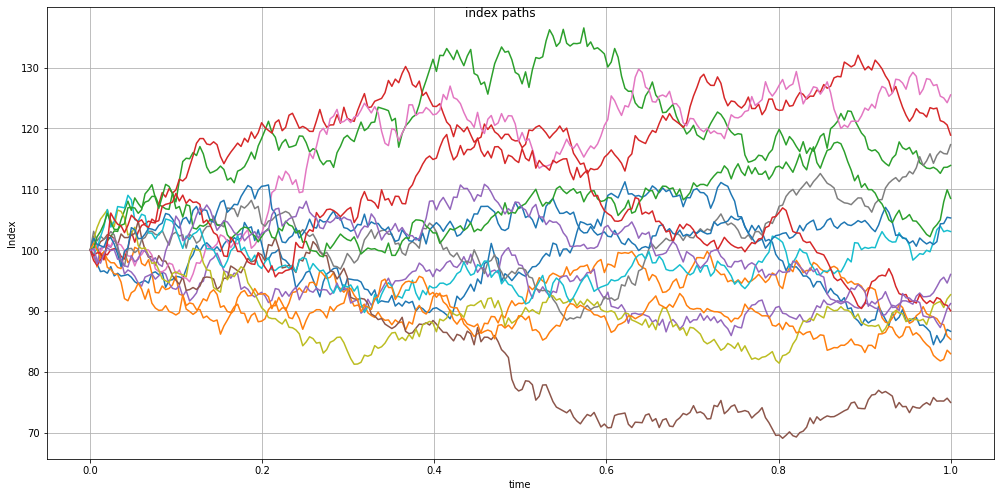

In [11]:
plot_random_paths_index(time,index_level,'index paths')

In [12]:
def Index_vol(index_value: np.ndarray,
              heston_params: HestonParameters,
              simulated_paths: dict # содержит как траектории цен, так и их волатильности
              ) -> np.ndarray:

  # ф-ия вычисляет волатильность индекса в предположениях модели Хестона 

  asset_paths = simulated_paths["asset"]
  volatility_paths = np.sqrt(simulated_paths["volatility"])
  volatility_paths = np.maximum(1e-5,volatility_paths)

  N, corMatrix, v0, kappa, vbar, gamma = heston_params.N, heston_params.corMatrix, \
                      heston_params.v0, heston_params.kappa, heston_params.vbar, heston_params.gamma
  
  sqrtCorMatrix=np.linalg.cholesky(corMatrix)

  #initialize zero arrays for index volatility
  index_vol = np.zeros([np.shape(asset_paths)[-2], np.shape(asset_paths)[-1]])
  
  N=np.shape(asset_paths)[0]
  #print(N)
  coefficients_vec=np.zeros([2*N,np.shape(asset_paths)[1]])
  for i in range(np.shape(asset_paths)[-1]) :
    denominator = np.sum(1/(volatility_paths[:,:,i]), axis=0)
    for j in range(N) : 
      coefficients_vec[j] = asset_paths[j,:,i]/denominator/index_value[:,i]
      coefficients_vec[N+j] = -0.5*asset_paths[j,:,i]*(1/np.power(volatility_paths[j,:,i],2))*gamma[j] \
                                  *(denominator-1/(volatility_paths[j,:,i]))/denominator**2/index_value[:,i]
    index_vol[:,i]=np.sqrt(np.sum(np.power(np.matmul(coefficients_vec.T,sqrtCorMatrix),2), axis=1))
    #if(i==0) : print(np.matmul(coefficients_vec.T,sqrtCorMatrix)[10])
    #if(i==0) : print(np.power(np.matmul(coefficients_vec.T,sqrtCorMatrix)[10],2))
  return index_vol

In [13]:
index_vol=Index_vol(index_level,heston_parameters,paths)

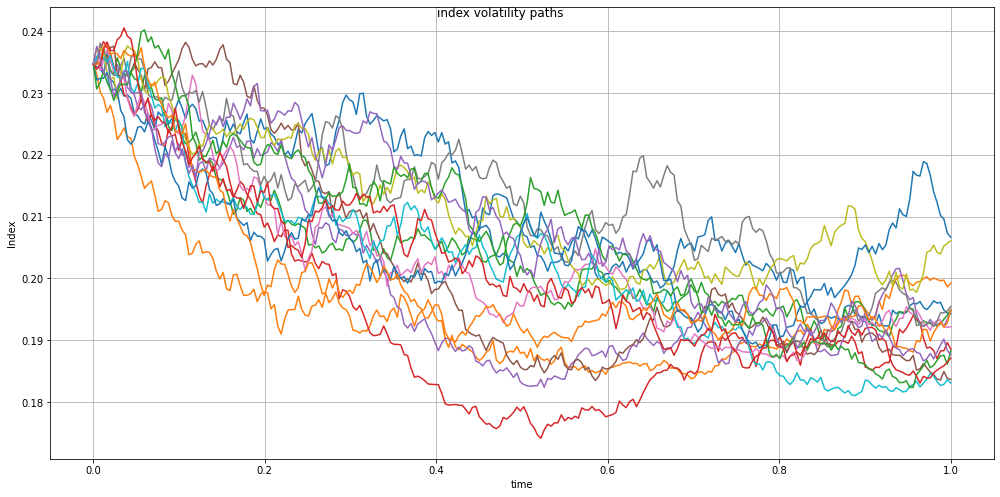

In [14]:
plot_random_paths_index(time,index_vol,'index volatility paths')

In [15]:
def delta_hedge_PnL(dt: int, # число дней между хеджированием
                    index_value: np.ndarray,
                    option: StockOption,
                    state: MarketState,
                    current_day: int,  # число дней с момента продажи опциона
                    indicator: bool # индиктор равен 1, если PnL вычисляется на момент экспирации
                    ) -> np.ndarray :

  # пока что не поддерживается ситуация, когда индикатор 0, т.к. тогда необходимо как-то вчислять цену опциона
  
  expiration_time=252*option.expiration_time
  new_state = dataclasses.replace(state)
  new_option = dataclasses.replace(option)
  numberOfShares = delta(option,state)
  riskFree = price(option,state) - numberOfShares*index_value[:,0]
  i=0
  while(i<current_day) :
    new_state.stock_price = index_value[:,i]
    new_option.expiration_time-=dt/252
    numberOfShares_new = delta(new_option,new_state)
    riskFree = (numberOfShares - numberOfShares_new)*index_value[:,i] + \
                                            riskFree*np.exp(dt/252*new_state.interest_rate)
    numberOfShares = numberOfShares_new
    i+=dt
  #print(index_value.shape[1]-i+dt)
  if(indicator) : 
    return numberOfShares*index_value[:,-1] + riskFree*np.exp((index_value.shape[1]-i+dt)/252*\
                               new_state.interest_rate) - np.maximum(0,index_value[:,-1]-option.strike_price)
  else : 
    new_state.stock_price = index_value[:,current_day]
    new_option.expiration_time-=dt/252
    return numberOfShares*index_value[:,current_day] + riskFree*np.exp((index_value.shape[1]-i+dt)/252*\
                               new_state.interest_rate)# - price(new_option,new_state)

Данные для проверки следующие : стартовые цены 100, страйк 100, maturity 1 год, ставка 0.01, мажоранта для волатильности 0.3, частота хеджирования 1 день.

---



---



In [16]:
option = StockOption(strike_price=100, expiration_time=1, is_call=True)
state = MarketState(stock_price = index_level[:,0], interest_rate = 0.01, volatility=0.3)

In [17]:
PnL=delta_hedge_PnL(1,index_level,option,state,252,True)

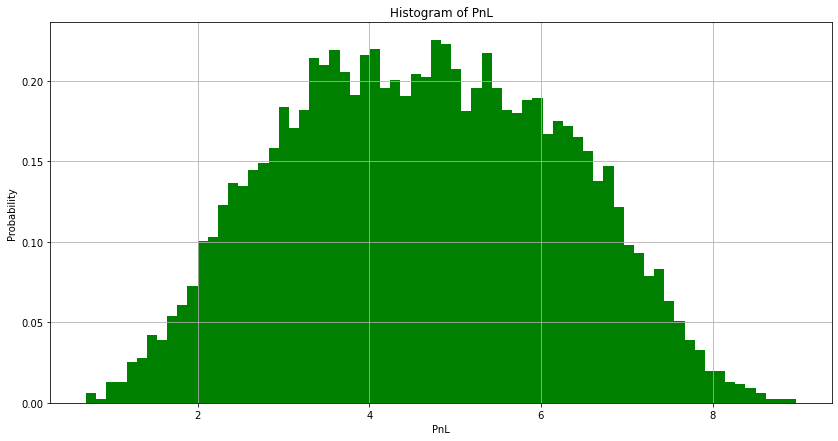

In [18]:
plt.figure(figsize=(14,7))
plt.hist(PnL, 70, density=True, facecolor='g')
plt.xlabel('PnL')
plt.ylabel('Probability')
plt.title('Histogram of PnL')
#plt.xlim(-1, 160)
#plt.ylim(0, )
plt.grid(True)
plt.show()

Теперь посмотрим, что было бы с PnL для опциона на low-vol индекс на российские акции

In [19]:
price1=yf.download('YNDX.ME',start='2020-1-1')
price2=yf.download('SBER.ME',start='2020-1-1')
price3=yf.download('GAZP.ME',start='2020-1-1')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [20]:
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

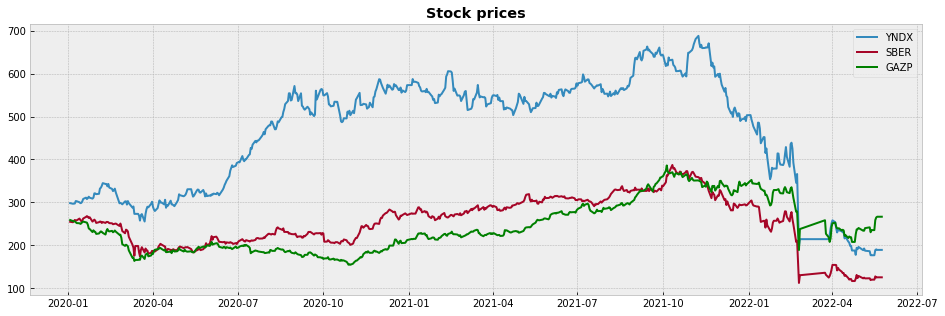

In [21]:
fig = plt.figure(figsize=(16, 5))

plt.plot(price1['Close']/9,label='YNDX')
#plt.legend('YNDX')
plt.plot(price2['Close'],label='SBER')
#plt.legend('SBER')
plt.plot(price3['Close'],label='GAZP',color='green')
plt.legend()

plt.title("Stock prices", weight="bold")

plt.show()

Вычисления проводились при :  maturity 200 дней, опцион ATM call, ставка 0.01, мажоранта для волатильности 0.07.

In [22]:
window_size=252

In [23]:
vol1=np.array(np.log(price1['Close']).diff().rolling(window=window_size).var().iloc[-200:]).reshape([1,-1])
vol2=np.array(np.log(price2['Close']).diff().rolling(window=window_size).var().iloc[-200:]).reshape([1,-1])
vol3=np.array(np.log(price3['Close']).diff().rolling(window=window_size).var().iloc[-200:]).reshape([1,-1])
pr1=np.array(price1['Close'].iloc[-200:]).reshape([1,-1])
pr2=np.array(price2['Close'].iloc[-200:]).reshape([1,-1])
pr3=np.array(price3['Close'].iloc[-200:]).reshape([1,-1])

In [24]:
paths_real = {"asset": np.stack((pr1,pr2,pr3)),\
         "volatility": np.stack((vol1,vol2,vol3))}

In [25]:
index_value_real=simulate_paths_Index(paths_real)

In [26]:
option_ = StockOption(strike_price = index_value_real[0,0], expiration_time = 200/252, is_call = True)
state_ = MarketState(stock_price = index_value_real[0,0], interest_rate = 0.01, volatility = 0.07)

In [27]:
print('Pnl:',delta_hedge_PnL(1,index_value_real,option_,state_,index_value_real.shape[-1],True)[0])

Pnl: -91.74164232723456


In [28]:
vol=pd.DataFrame(np.log(index_value_real).T).diff().rolling(window=20).std()

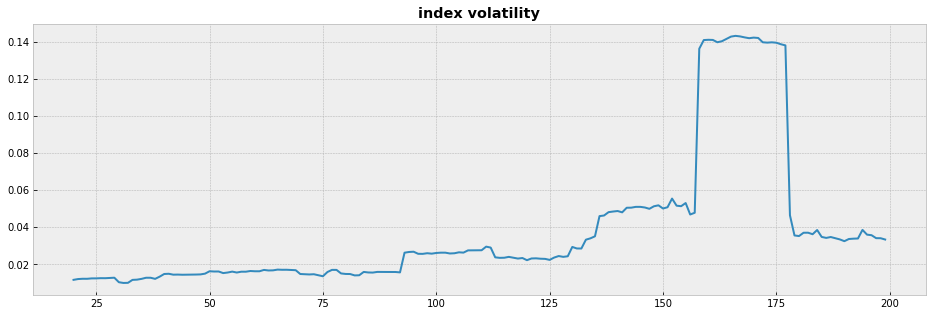

In [29]:
fig = plt.figure(figsize=(16, 5))

plt.plot(vol[vol.notna().all(1)])

plt.title('index volatility', weight="bold")

plt.show()

# Новый раздел

In [30]:
def BS_price(time: Union[float, np.ndarray],
                         type: str,
                         state: MarketState,
                         strike_price: float,
                         rho: float,
                         n_simulations: int = 10**7) -> float:
    
    r, s0, volatility = state.interest_rate, state.stock_price, state.volatility
    volatility=volatility.reshape((2,1))
    Z = np.random.normal(size=(s0.shape[0], n_simulations))
    Z[-1] = rho*Z[0]+(1-rho**2)**(0.5)*Z[-1]
    Z = (s0*(np.exp(-0.5*volatility**2*time + volatility*np.sqrt(time)*Z)).T).T
    #print(Z[0])
    if(type=='spread_for_equity') : 
      Z*=np.exp(r*time)
      price = np.mean(np.maximum(0,Z[0] - Z[1] - strike_price))
    if(type=='spread_for_equity_ind') :
       Z*=np.exp(r*time)
       price = np.mean(np.maximum(0,np.sum(Z,axis=0) - strike_price))
    #if(type!='ind_option') : price = np.mean(np.maximum(0,Z[0] - Z[1] - strike_price))
    #else : price = np.mean(np.maximum(0,np.sum(Z,axis=0) - strike_price))
    
    return price*np.exp(-r*time)

In [31]:
def Approx_price(time: Union[float, np.ndarray],
                         type: str,
                         state: MarketState,
                         strike_price: float,
                         rho: float,
                         a: float,
                         b: float) -> float:
    
    r, s0, volatility = state.interest_rate, state.stock_price, state.volatility

    #ind=1

    '''if(type!='spread'): 
      b=-b 
      ind=-1'''
      
    sigma = np.sqrt(volatility[0]**2-2*b*rho*volatility[0]*volatility[1]+b**2*volatility[1]**2)
    d1 = (np.log(s0[0]/a)+(0.5*volatility[0]**2-b*rho*volatility[0]*volatility[1]+0.5*b**2*volatility[1]**2)*time)/(sigma*np.sqrt(time))
    d2 = (np.log(s0[0]/a)+(-0.5*volatility[0]**2+rho*volatility[0]*volatility[1]+0.5*b**2*volatility[1]**2-b*volatility[1]**2)*time)/(sigma*np.sqrt(time))
    d3 = (np.log(s0[0]/a)+(-0.5*volatility[0]**2+0.5*b**2*volatility[1]**2)*time)/(sigma*np.sqrt(time))

    # if(type=='spread_for_equity') :
    #   d1 = (np.log(s0[0]/a)+(0.5*volatility[0]**2-b*rho*volatility[0]*volatility[1]+0.5*b**2*volatility[1]**2)*time + r*time)/(sigma*np.sqrt(time))
    #   d2 = (np.log(s0[0]/a)+(-0.5*volatility[0]**2+rho*volatility[0]*volatility[1]+0.5*b**2*volatility[1]**2-b*volatility[1]**2)*time + r*time)/(sigma*np.sqrt(time))
    #   d3 = (np.log(s0[0]/a)+(-0.5*volatility[0]**2+0.5*b**2*volatility[1]**2)*time + r*time)/(sigma*np.sqrt(time))
    #   return s0[0]*sps.norm.cdf(d1)-s0[1]*sps.norm.cdf(d2)-np.exp(-r*time)*strike_price*sps.norm.cdf(d3)

    return np.exp(-r*time)*(s0[0]*sps.norm.cdf(d1)-s0[1]*sps.norm.cdf(d2)-strike_price*sps.norm.cdf(d3))

In [32]:
state = MarketState(stock_price = np.exp(np.array([0.02,0.03]))*np.array([110,100])*np.exp(-0.05), interest_rate = 0.05, volatility=np.array([0.1,0.15]))


In [33]:
strike=25
exp_time=1
corr=0
BS_price(exp_time,'spread_for_equity',state,strike,corr)

1.958078624709702

In [34]:
state.stock_price[0]*=np.exp(state.interest_rate*exp_time)
state.stock_price[1]*=np.exp(state.interest_rate*exp_time)

a=state.stock_price[1]+strike
b=state.stock_price[1]/a
#b=200
Approx_price(exp_time,'spread',state,strike,corr,a,b)

1.9617318266984862

In [35]:
state = MarketState(stock_price = np.array([2.119,0.909]), interest_rate = 0.07, volatility=np.array([-0.15,0.25]))
strike=1
exp_time=1
corr=-0.6

In [36]:
110*BS_price(exp_time,'spread_for_equity',state,strike,corr)

32.3410373617488

In [37]:
state.stock_price[0]*=np.exp(state.interest_rate*exp_time)
state.stock_price[1]*=np.exp(state.interest_rate*exp_time)

a=state.stock_price[1]+strike
b=state.stock_price[1]/a
#b=200
110*Approx_price(exp_time,'spread',state,strike,corr,a,b)

32.321059969186685

In [38]:
def Approx_price_IndOption_BS(exp_time: Union[float, np.ndarray],
                         state: MarketState,
                         strike_price: Union[float, np.ndarray],
                         rho: float) -> float:
  state1 = MarketState(stock_price=np.array([strike_price/state.stock_price[0],state.stock_price[1]/state.stock_price[0]]),
                      interest_rate = 0, volatility=np.array(
                      [-state.volatility[0],
                      (state.volatility[0]**2-2*rho*state.volatility[0]*state.volatility[1]+state.volatility[1]**2)**(0.5)]))
  
  state1.stock_price[0]*=np.exp(-state.interest_rate*exp_time)
  #state1.stock_price[1]*=np.exp(state1.interest_rate*exp_time)

  a1=state1.stock_price[1]+1
  b1=state1.stock_price[1]/a1

  rho1 = (state.volatility[1]*rho-state.volatility[0])/\
        (state.volatility[0]**2-2*rho*state.volatility[0]*state.volatility[1]+state.volatility[1]**2)**(0.5)

  #print(state1.stock_price[0],state1.stock_price[1],state1.volatility[0],state1.volatility[1],rho1)

  #print('approx',Approx_price(exp_time,'spread',state1,1,rho1,a1,b1))
  price1 = Approx_price(exp_time,'spread',state1,1,rho1,a1,b1) + \
                      (state.stock_price[1]-np.exp(-state.interest_rate*exp_time)*strike_price)/state.stock_price[0] + 1
  #print(state.stock_price[0]*price1)
  #print(BS_price(time,'!',state,strike_price,rho))
  return state.stock_price[0]*price1 #- BS_price(time,'ind_option',state,strike_price,rho)

In [39]:
state = MarketState(stock_price = np.array([110,100]), interest_rate = 0.0, volatility=np.array([0.15,0.2]))

In [40]:
strike=100
exp_time=1
corr=0
res=Approx_price_IndOption_BS(exp_time,state,strike,corr)
print(res)

110.00000000046315


In [41]:
BS_price(exp_time,'spread_for_equity_ind',state,strike,corr)

109.98974757387121

In [42]:
state.stock_price[0]+state.stock_price[1]-strike*np.exp(-state.interest_rate*exp_time)

110.0

In [43]:
def simulate_paths_Vol_Only(time: Union[float, np.ndarray],
                                n_simulations: int,
                                heston_params: HestonParameters) -> np.ndarray:
    '''
    Simulates price and volatility process evaluating it at given time points 
    using Euler scheme. 
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        heston_params (HestonParameters): parameters of Heston model.
        
    Returns:
        dict: simulated volatility paths.
    '''
    
    
    N, corMatrix, v0, kappa, vbar, gamma = heston_params.N, heston_params.corMatrix, \
                      heston_params.v0, heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    sqrtCorMatrix=np.linalg.cholesky(corMatrix)

    # initialize noise arrays
    Z = np.random.normal(size=(N, n_simulations, np.shape(time)[0]))
    
    #initialize zero array for volatility values
    V = np.zeros([N, n_simulations, np.shape(time)[0]])
    for i in range(N): V[i,:,0] = v0[i]

    for i in range(1,np.shape(time)[0]) :
      dt=time[i]-time[i-1]
      kappa*((vbar-V[:,:,i-1].T))
      V[:,:,i]=V[:,:,i-1]+(kappa*(vbar-V[:,:,i-1].T)).T*dt+\
                                                 (gamma*(np.sqrt(V[:,:,i-1]*dt).T)).T*Z[:,:,i-1]
      V[:,:,i]=np.maximum(V[:,:,i],0)

    
    return V

In [44]:
strike=np.arange(10,200,10)
exp_time=1
corr=0
state = MarketState(stock_price = np.array([110,100]), interest_rate = 0.05, volatility=np.array([0.15,0.2]))
time = np.linspace(0, exp_time, 252*exp_time)
N=2
heston_parameters = HestonParameters(N=N ,corMatrix=np.eye(2*N),
                                     kappa = [3,3], gamma = [0.15,0.1], 
                                     vbar = [0.15,0.2], 
                                     v0 = [0.15,0.2])

n_simulations = 10000

vol_paths = simulate_paths_Vol_Only(time, n_simulations, heston_parameters)

paths = simulate_paths_heston_euler(time, n_simulations, state, heston_parameters)

In [45]:
index_level=simulate_paths_Index(paths)

In [46]:
def Approx_price_IndOption(exp_time: float,
                           time: Union[float, np.ndarray],
                           state: MarketState,
                           strike_price: Union[float, np.ndarray],
                           corr: float,
                           n_simulations: int,
                           heston_params: HestonParameters) -> float :
  paths = simulate_paths_Vol_Only(time, n_simulations, heston_parameters)
  V = paths.mean(axis=2)#*exp_time
  true_paths=np.sqrt(paths)
  price=0
  new_state = dataclasses.replace(state)
  for i in range(paths.shape[1]) :
    # new_state = MarketState(stock_price=np.array([state.stock_price[0]*(1/true_paths[0,i,-1])/(1/true_paths[0,i,-1]+1/true_paths[1,i,-1]),
    #                                            state.stock_price[1]*(1/true_paths[1,i,-1])/(1/true_paths[0,i,-1]+1/true_paths[1,i,-1])]),
    #                                            interest_rate = state.interest_rate, volatility=np.array([np.sqrt(V[0,i]),np.sqrt(V[1,i])]))

    new_state.stock_price=np.array([state.stock_price[0]*(1/true_paths[0,i,-1])/(1/true_paths[0,i,-1]+1/true_paths[1,i,-1]),
                                    state.stock_price[1]*(1/true_paths[1,i,-1])/(1/true_paths[0,i,-1]+1/true_paths[1,i,-1])])
    new_state.interest_rate = state.interest_rate
    new_state.volatility=np.array([np.sqrt(V[0,i]),np.sqrt(V[1,i])])

    price+=Approx_price_IndOption_BS(exp_time,new_state,strike_price,corr)
  return price/paths.shape[1]

In [47]:
def MC_price_Ind(exp_time: float,
                 time: Union[float, np.ndarray],
                 state: MarketState,
                 strike: Union[float, np.ndarray],
                 n_simulations: int,
                 heston_params: HestonParameters) -> float:
  paths = simulate_paths_heston_euler(time, n_simulations, state, heston_parameters)
  index_level = simulate_paths_Index(paths)
  MC_price=0
  for i in range(index_level.shape[0]) :
    MC_price+=np.maximum(0,index_level[i,-1]-strike)
  return MC_price/index_level.shape[0]*np.exp(-state.interest_rate*exp_time)

In [48]:
%%timeit
Approx_price_IndOption(exp_time,time,state,strike,corr,10000,heston_parameters)

5.73 s ± 2.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
Approx_price_IndOption(exp_time,time,state,strike,corr,10000,heston_parameters)

4.4 s ± 543 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit
MC_price_Ind(exp_time,time,state,strike,10000,heston_parameters)

1.39 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
Approx_price_IndOption(exp_time,time,state,strike,corr,10000,heston_parameters)-MC_price_Ind(exp_time,time,state,strike,10000,heston_parameters)

array([ 0.33113529,  0.3311353 ,  0.33108988,  0.32910569,  0.32450782,
        0.31282886,  0.28536023,  0.22892453,  0.16994804,  0.08891485,
       -0.02106744, -0.07322238, -0.09206119, -0.09329598, -0.102058  ,
       -0.10163477, -0.10024501, -0.09788391, -0.08926221])

In [52]:
# for i in range(10,200,10):
#   print(i,':')
#   price=Approx_price_IndOption(vol_path,exp_time,state,i,corr)
#   print('Approx price: ',price)
#   MC_price=0
#   for j in range(index_level.shape[0]) :
#     MC_price+=np.maximum(0,index_level[j,-1]-i)
#   MC_price/=(index_level.shape[0]/np.exp(-state.interest_rate*exp_time))
#   print('MC price: ',MC_price)
#   print('diff: ',abs(MC_price-price))

In [53]:
def Approx_price_v2(time: Union[float, np.ndarray],
                         type: str,
                         state: MarketState,
                         strike_price: float,
                         rho: float,
                         a: float,
                         b: float) -> float:
    
    r, s0, volatility = state.interest_rate, state.stock_price, state.volatility

      
    sigma = np.sqrt(volatility[0]**2-2*b*rho*volatility[0]*volatility[1]+b**2*volatility[1]**2)
    d1 = (np.log(s0[0]/a)+(0.5*volatility[0]**2-b*rho*volatility[0]*volatility[1]+0.5*b**2*volatility[1]**2)*time)/(sigma*np.sqrt(time))
    d2 = (np.log(s0[0]/a)+(-0.5*volatility[0]**2+rho*volatility[0]*volatility[1]+0.5*b**2*volatility[1]**2-b*volatility[1]**2)*time)/(sigma*np.sqrt(time))
    d3 = (np.log(s0[0]/a)+(-0.5*volatility[0]**2+0.5*b**2*volatility[1]**2)*time)/(sigma*np.sqrt(time))

    return np.exp(-r*time)*(s0[0]*sps.norm.cdf(d1)-s0[1]*sps.norm.cdf(d2)-strike_price*sps.norm.cdf(d3))

In [54]:
def Approx_price_IndOption_BS_v2(exp_time: Union[float, np.ndarray],
                         state: MarketState,
                         strike_price: Union[float, np.ndarray],
                         rho: float) -> float:
  state1 = MarketState(stock_price=np.array([np.matmul(strike_price,np.reciprocal(state.stock_price[0])),
                                             (state.stock_price[1]/state.stock_price[0])]),
                      interest_rate = 0, volatility=np.array(
                      [-state.volatility[0],
                      (state.volatility[0]**2-2*rho*state.volatility[0]*state.volatility[1]+state.volatility[1]**2)**(0.5)]))
  
  state1.stock_price[0]*=np.exp(-state.interest_rate*exp_time)
  #state1.stock_price[1]*=np.exp(state1.interest_rate*exp_time)

  a1=state1.stock_price[1]+1
  b1=state1.stock_price[1]/a1

  rho1 = (state.volatility[1]*rho-state.volatility[0])/\
        (state.volatility[0]**2-2*rho*state.volatility[0]*state.volatility[1]+state.volatility[1]**2)**(0.5)

  #print(state1.stock_price[0],state1.stock_price[1],state1.volatility[0],state1.volatility[1],rho1)

  #print('approx',Approx_price(exp_time,'spread',state1,1,rho1,a1,b1))
  price1 = Approx_price_v2(exp_time,'spread',state1,1,rho1,a1,b1) + \
                      (state.stock_price[1]-np.exp(-state.interest_rate*exp_time)*strike_price)/state.stock_price[0] + 1
  #print(state.stock_price[0]*price1)
  #print(BS_price(time,'!',state,strike_price,rho))
  return state.stock_price[0]*price1 #- BS_price(time,'ind_option',state,strike_price,rho)

In [55]:
def Approx_price_IndOption_v2(exp_time: float,
                           time: Union[float, np.ndarray],
                           state: MarketState,
                           strike_price: Union[float, np.ndarray],
                           corr: float,
                           n_simulations: int,
                           heston_params: HestonParameters) -> float :
  strike_price=strike_price.reshape(-1,1)
  

  paths = simulate_paths_Vol_Only(time, n_simulations, heston_parameters)
  V = paths.mean(axis=2)#*exp_time
  true_paths=np.sqrt(paths)

  new_state = dataclasses.replace(state)
  new_state.stock_price = np.array([(state.stock_price[0]*(1/true_paths[0,:,-1])/(1/true_paths[0,:,-1]+1/true_paths[1,:,-1])).reshape(1,-1),
                                    (state.stock_price[1]*(1/true_paths[1,:,-1])/(1/true_paths[0,:,-1]+1/true_paths[1,:,-1])).reshape(1,-1)])
  
  new_state.interest_rate = state.interest_rate
  new_state.volatility = np.array([np.sqrt(V[0,:]),np.sqrt(V[1,:])])

  price = Approx_price_IndOption_BS_v2(exp_time,new_state,strike_price,corr)
  #print(price.shape)
  return price.mean(axis=1)

In [56]:
Approx_price_IndOption_v2(exp_time,time,state,strike,corr,1000,heston_parameters)-MC_price_Ind(exp_time,time,state,strike,100000,heston_parameters)

array([ 0.14656639,  0.1465664 ,  0.14651605,  0.1460952 ,  0.14183951,
        0.12574855,  0.09185722,  0.03704041, -0.02645259, -0.08406736,
       -0.12967879, -0.15463564, -0.16552539, -0.16870497, -0.15567696,
       -0.13263268, -0.10581841, -0.07866285, -0.05474254])

In [57]:
Approx_price_IndOption_v2(exp_time,time,state,strike,corr,10000,heston_parameters)-MC_price_Ind(exp_time,time,state,strike,100000,heston_parameters)

array([-0.01723996, -0.01723995, -0.01724741, -0.01793039, -0.0228672 ,
       -0.03886178, -0.07150429, -0.11960387, -0.1748854 , -0.21649751,
       -0.24594748, -0.24031933, -0.2230957 , -0.19835179, -0.17167569,
       -0.14418796, -0.12082904, -0.09618368, -0.07305398])

In [58]:
Approx_price_IndOption_v2(exp_time,time,state,strike,corr,100000,heston_parameters)-MC_price_Ind(exp_time,time,state,strike,100000,heston_parameters)

array([-0.08760331, -0.0876033 , -0.08758971, -0.08737335, -0.09046128,
       -0.1037506 , -0.13499533, -0.17746271, -0.22644852, -0.27580496,
       -0.30441885, -0.31532821, -0.30170858, -0.27498208, -0.23513455,
       -0.1903765 , -0.1559005 , -0.12895603, -0.10757408])

In [59]:
%%timeit
Approx_price_IndOption_v2(exp_time,time,state,strike,corr,10000,heston_parameters)

707 ms ± 79.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%%timeit
MC_price_Ind(exp_time,time,state,strike,10000,heston_parameters)

1.43 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
